# Support Vector Machine

$\newcommand{\vec}{\mathbf}$
* Objective: classify vectors into positive and negative samples based on labled training data
* Collection of input vectors $\mathbf x_i$ for $i=1,\dots,N$ and $\mathbf x_i \in {\rm I\!R}^m$
* For every $\vec x_i$ in the training data set we have a label $y_i$ (+1 or -1).

* `x[i,:]` corresponds to $\vec x_i$

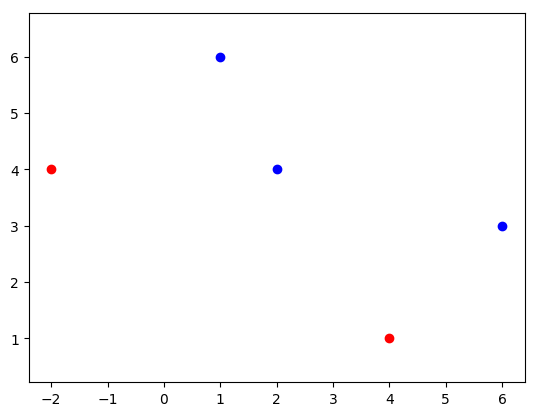

(-2.4, 6.4, 0.75, 6.25)

In [52]:
using PyPlot

x = [-2 4;
     4  1;
     1  6;
     2  4;
     6  3]

y = [-1,-1,1,1,1]

function plotdata(x,y)
  ind = find(y .== -1)
  plot(x[ind,1],x[ind,2],"ro")
  ind = find(y .== 1)
  plot(x[ind,1],x[ind,2],"bo")
  axis("equal")
end

plotdata(x,y)

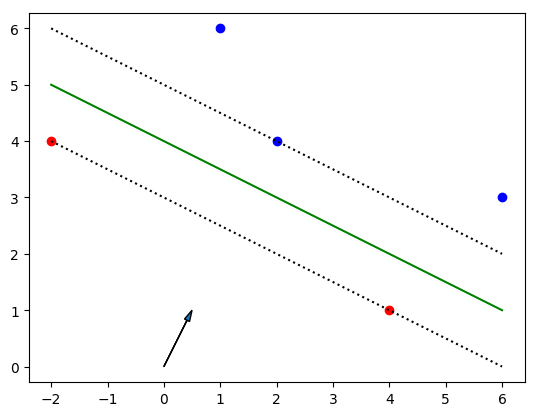

PyObject <matplotlib.patches.FancyArrow object at 0x7fd237f017d0>

In [53]:
function plotline(w,b;kwargs...)
  t = -2:6
  plot(t,-(b + w[1]*t)/w[2]; kwargs...)
end

plotdata(x,y)
plotline([0.5, 1], -4; color = "g")
plotline([0.5, 1], -5; color = "k", linestyle=":")
plotline([0.5, 1], -3; color = "k", linestyle=":")
arrow(0,0,0.5, 1; head_width=0.1, head_length=0.2, length_includes_head = true )


For positive samples:

$$
 \mathbf w^T \mathbf x_+ + b \ge 1 
$$

For negative samples:

$$
 \mathbf w^T \mathbf x_- + b \le -1 
$$

For two samples at the limit of this "road" ($\vec x_+$ and $\vec x_-$) we have:
 
$$
 \mathbf w^T \mathbf x_+ + b = 1 \\
 \mathbf w^T \mathbf x_- + b = -1 
$$


The width of the "road" is computed by projecting the vector $(\vec x_+ - \vec x_-)$
to a normal vector perpendicular to the central line (vector $\frac{\vec w}{\| \vec w \|}$):

$$
\left|(\vec x_+ - \vec x_-)^T  \frac{\vec w}{\| \vec w \|} \right| =
\left|\vec x_+^T \vec w - \vec x_-^T \vec w \right| \frac{1}{\| \vec w \|}  =
\left|1-b - (-1 -b) \right|  \frac{1}{\| \vec w \|}  =
\frac{2}{\|\vec w\|}
$$



Maximize $ \frac{2}{\|\vec w\|}$ under the inequality constrain:

$$
 y_i (\mathbf w^T \mathbf x_i + b) \ge 1 
$$


Maximizing $ \frac{2}{\|\vec w\|}$ is the same as minimizing $\frac{1}{2} \| \mathbf w \|^2$.

The contraint is introduced using the Lagrange multipliers $\alpha_i$

$$
L(\vec w,b,\alpha_1,\alpha_2,...) = \frac{1}{2} \| \mathbf w \|^2 - \sum_i \alpha_i ( y_i (\mathbf w^T \mathbf x_i + b) -1 )
$$

$$
\frac{\partial L}{\partial \vec w} = \vec w - \sum_i \alpha_i \vec y_i \vec x_i = 0
$$

Thus $\vec w$ is a linear sum of the samples $\vec x_i$: 

$$
\vec w = \sum_i \alpha_i y_i \vec x_i
$$

$$
\frac{\partial L}{\partial b} = -\sum_i \alpha_i y_i = 0 \rightarrow \sum_i \alpha_i y_i = 0
$$

$$
L = \frac{1}{2} \left( \sum_i \alpha_i y_i \vec x_i^T \right)  \left( \sum_j \alpha_j y_j \vec x_j \right) 
- 
\sum_i \alpha_i  y_i  \mathbf x_i^T \left(\sum_j \alpha_j y_j \vec x_j \right) 
- b \sum_i \alpha_i y_i
+ \sum_i \alpha_i 
$$

Maximum of 

$$
L = \sum_i \alpha_i 
- \frac{1}{2} 
\sum_i \sum_j 
\alpha_i \alpha_j y_i y_j \vec x_i^T \vec x_j
$$

with the contraints $\alpha_i \ge 0$ and $\sum_i \alpha_i y_i = 0$.
* It depends only on the dot product of pairs of samples $\vec x_i^T \vec x_j$
* maximization of $L$ is a convex problem -> there is only one maximum (no local maximum)

Decision rule

$$
\mbox{if}\;\;
\sum_i \alpha_i  y_i  \vec x_i^T \vec u > 0 \;\;\mbox{then $\vec u$ is a positive sample}
$$

Or a negative sample otherwise.

To compute $b$:

$$
y_i (\vec w^T \vec x_i + b) - 1 = 0
$$


$$
b = y_i - \vec w^T \vec x_i
$$


In [54]:
length(y)

5

In [55]:
function L(α,x,y)
    N = length(y)
    Lval = sum(α)
    for j = 1:N
       for i = 1:N
           Lval -= 0.5 * α[i] * α[j] * y[i] * y[j] * (x[i,:] ⋅ x[j,:]) 
        end
    end
    #@show α,Lval
    return Lval
end

using NLopt
N = length(y)
#opt = Opt(:GN_DIRECT, N)
opt = Opt(:LN_COBYLA, N)
#opt = Opt(:LD_MMA, N)

max_objective!(opt, (α,grad) -> L(α,x,y))
lower_bounds!(opt, zeros(N))
equality_constraint!(opt, (α,grad) -> sum(y.*α))

xtol_rel!(opt,1e-6)
maxeval!(opt,10000)

minL,α,ret = optimize(opt, ones(N))

(0.6249999999944293, [0.291667, 0.333333, 3.29898e-22, 0.625, 5.25802e-22], :XTOL_REACHED)

Points travers by the dottes black line are called support vectors.
$\vec x_i$ is a support vector if $\alpha_i > 0$.
Coordinates of support vector:

Compute $\vec w$ and $b$:

In [56]:
w = zeros(size(x,2))
for i = 1:N
   w += α[i] * y[i] * x[i,:]
end

i = findfirst(α .> eps()) # for any i such that α[i] > 0
b = y[i] - w' * x[i,:]

@show w,b,w/b

(w, b, w / b) = ([0.500003, 0.999999], -3.999989136534672, [-0.125001, -0.25])


([0.500003, 0.999999], -3.999989136534672, [-0.125001, -0.25])

In [57]:
2/norm(w)

1.7888537844659604

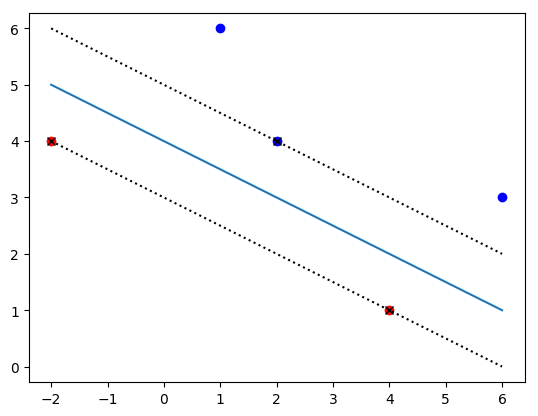

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd237e91990>

In [58]:


plotdata(x,y)
plotline(w,b)
plotline(w,b-1; color = "k", linestyle=":")
plotline(w,b+1; color = "k", linestyle=":")

isupport = find(α .> eps())
plot(x[isupport,1],x[isupport,2],"x",color="k")

If sample are not linearily separable, then one can introduce a transformation function $\vec \phi(\vec x)$ such that the transformed samples are separable.

Kernel $K$

$$
K(\vec x_i,\vec x_j) = \phi(\vec x_i)^T \phi(\vec x_j)
$$

Possible kernels:

* $K(\vec u,\vec v) = (\vec u^T \vec v + 1)^n$
* $K(\vec u,\vec v) = \exp(- \| \vec u - \vec v \| / \sigma ) $

